In [1]:
#импортируем разное
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np
import matplotlib.pyplot as plt

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
#загрузим модели
localizator = tf.keras.models.load_model('my_bb_model.h5')
classifier = tf.keras.models.load_model('my_classifier.h5')

In [3]:
#функция работы с нейросетями: подготовка изображения, детекция
#на выходе три массива: координаты (10,4) , классы (10) , вероятности (10)

def Detect_objects(image):
    #подготовка картинки
    image = tf.cast(image, dtype = tf.float32) / 256
    small_image = tf.image.resize(image, (128, 128))
    big_image = tf.image.resize(image, (1024, 1024))
    image_exp = tf.expand_dims(small_image, axis = 0)
    
    #локализация
    bb_cords = localizator(image_exp)
    bb_cords = tf.squeeze(bb_cords, axis = 0)
    
    #нормализация по размеру картинки
    bb_cords = (bb_cords+1)/2*128
    bb_cords = tf.reshape(bb_cords, [10, 3])
    
    #разделяем на элементы
    fxmin, ymin, fxmax = tf.split(bb_cords, 3, axis = 1)
    
    #нормализуем
    xmin = tf.minimum(fxmin, fxmax)
    xmax = tf.maximum(fxmin, fxmax)
    
    xmin = tf.clip_by_value(xmin, 0, 128)
    ymin = tf.clip_by_value(ymin, 0, 128)
    
    size = xmax - xmin
    
    #сумма координаты и размера должны быть <= 128
    xsize = tf.clip_by_value(size, 1, 128 - xmin)
    ysize = tf.clip_by_value(size, 1, 128 - ymin)
    
    #нарезаем и собираем в массив (10, 32, 32, 3)
    ymin*= 8
    xmin*= 8
    ysize*= 8
    xsize*= 8
    for n in range(10):
        ii = tf.image.crop_to_bounding_box(big_image, int(ymin[n][0]), int(xmin[n][0]), int(ysize[n][0]), int(xsize[n][0]))
        ii = tf.image.resize(ii, (128,128))
        ii = tf.expand_dims(ii, axis = 0)
        if n == 0:
            cropped = ii 
        else:
            cropped = tf.concat([cropped, ii], axis = 0)
    
    #классифицируем
    probs = classifier(cropped)
    
    probs = probs.numpy()
    
    #считаем метки класса (индекс наибольшего среди вероятностей)
    ma = np.amax(probs, axis = 1)
    ma = np.expand_dims(ma, axis = 1)
    _, classes = np.where(probs == ma)
    
    #берем ту вероятность, которая наибольшая
    res_probs = []
    for a in range(10):
        res_probs.append(probs[a][classes[a]])
    
    #собираем координаты в нормальный вид
    cords = tf.concat([xmin/8, ymin/8, xmin/8+xsize/8, ymin/8+ysize/8], axis = 1)
    cords = cords.numpy()

    
    return cords, classes, res_probs
    
    

In [4]:
#th - вероятность, ниже которой рамки не отображаются
namespace = {0: 'NOTHING', 1: 'microchip' , 2: 'capacitor'}

def visualize(in_image, cords, classes, probs, th = 0.8):
    big_image = tf.image.resize(in_image, (1024,1024)).numpy() / 256
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    thickness = 2

    for i in range(len(cords)):
        if classes[i]!= 0 and probs[i] >= th:
            #введем цвета для всех обьектов
            if classes[i] == 1:
                color = (1, 0, 0)
            if classes[i] == 2:
                color = (0, 1, 0)
            text = namespace[classes[i]] + ' ' + str(probs[i]*100) + '%'
            
            org = ((int(cords[i][0])*8,  int(cords[i][1])*8-10))
            #рисуем текст и квадраты
            big_image = cv2.putText(big_image, text, org, font, fontScale, color, thickness, cv2.LINE_AA)
            big_image = cv2.rectangle(big_image ,(int(cords[i][0])*8, int(cords[i][1])*8),(int(cords[i][2])*8,int(cords[i][3])*8),color,5)
            
        
    
    return big_image
    

In [5]:
#функция обьединяет две рамки одного класса в одну, если они пересекаются
#tau - порог IoU этих рамок чтобы их обьединить (0.1 - все подряд, 0.9 - только очень близкие)
#функцию можно применять несколько раз, результат улучшится

def prettify(cords, classes, probs, tau = 0.5):
    newcords = []
    newclasses = []
    newprobs = []
    
    for i1 in range(len(classes)):
        
        if classes[i1]!=0:
            found = False
            for i2 in range(len(classes)):
                if classes[i2]!=0 and  i1 != i2:
                    
                    #вычислим IoU - самый надежный способ определить совпадение
                    x_overlap = max(0, min(cords[i1][2], cords[i2][2]) - max(cords[i1][0], cords[i2][0]))
                    y_overlap = max(0, min(cords[i1][3], cords[i2][3]) - max(cords[i1][1], cords[i2][1]))
                    inter = x_overlap*y_overlap
                    area1 = (cords[i1][2] - cords[i1][0])*(cords[i1][3] - cords[i1][1])
                    area2 = (cords[i2][2] - cords[i2][0])*(cords[i2][3] - cords[i2][1])
                    union = area1+area2 - inter
                    IoU = inter/union
                    if IoU > tau:
                        
                        #считаем среднее по всем координатам между двух рамок
                        newcord = [(cords[i1][0]+ cords[i2][0])//2,(cords[i1][1]+ cords[i2][1])//2,(cords[i1][2]+ cords[i2][2])//2,(cords[i1][3]+ cords[i2][3])//2]
                        newcords.append(newcord)

                        newclasses.append(classes[i1])
                        newprobs.append(probs[i1])
                        
                        #обнуляем класс, чтобы больше не крутить эту рамку
                        classes[i1] = 0
                        classes[i2] = 0
                        found = True
                        
            #если ни с чем не обьединили, так и оставляем
            if found == False:
                newcords.append(cords[i1])
                newclasses.append(classes[i1])
                newprobs.append(probs[i1])
            
            
                        
    return newcords, newclasses, newprobs
                    


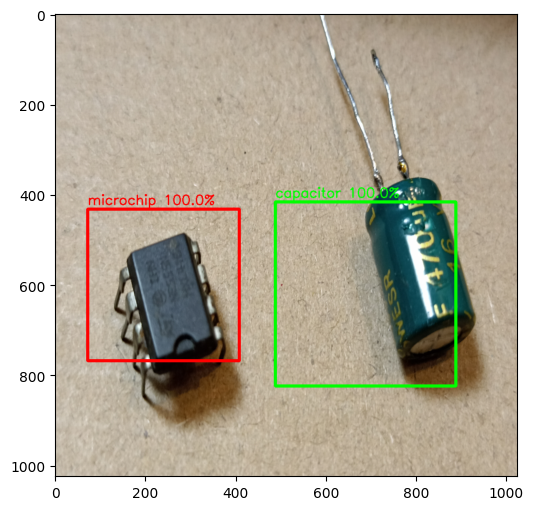

In [10]:
image = cv2.imread('C:/users/user/AI tests/krasnoteh_OD/images/IMG_20230812_135856.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cords, classes, probs = Detect_objects(image)
for i in range(1):
    cords, classes, probs = prettify(cords, classes, probs, 0.1)
result = visualize(image, cords, classes, probs, 0.5)
plt.figure(figsize=(10, 6))
ax = plt.subplot(1,1,1)
plt.imshow(result)
plt.show()

In [9]:
import numpy as np
import cv2 as cv
cap = cv.VideoCapture(4)

while True:
 
    ret, frame = cap.read()
    cords, classes, probs = Detect_objects(frame)
    for i in range(3):
        cords, classes, probs = prettify(cords, classes, probs, 0)
    result = visualize(frame, cords, classes, probs, 0.9)
 
    cv.imshow('frame', result)
    if cv.waitKey(1) == ord('q'):
        break

cap.release()
cv.destroyAllWindows()